# Covariance vs. Entropic Inference---Finite Shot Regime



In [8]:
import qnetti
import pennylane as qml
from pennylane import numpy as qnp
import qnetvo
import matplotlib.pyplot as plt
from functools import reduce
import json
from datetime import datetime

print(qnetvo.__version__)
print(qml.__version__)

0.4.1
0.28.0


In [34]:
qnp.random.seed(100)


def characteristic_matrix_inference(prep_node, num_steps, step_size, shots):
    vn_opt_kwargs = {"num_steps": num_steps, "step_size": step_size}
    mi_opt_kwargs = {"num_steps": num_steps, "step_size": step_size}
    dev_kwargs = {"shots": shots}
    char_mat, mi_opt_dict, vn_opt_dict = qnetti.optimize_characteristic_matrix(
        prep_node, vn_opt_kwargs=vn_opt_kwargs, mi_opt_kwargs=mi_opt_kwargs, dev_kwargs=dev_kwargs
    )
    return char_mat.tolist()


def covariance_matrix_inference(prep_node, num_steps, step_size, shots):
    cov_mat, opt_dict = qnetti.optimize_covariance_matrix(
        prep_node, step_size=step_size, num_steps=num_steps, dev_kwargs={"shots": shots}
    )
    return cov_mat.tolist()

In [35]:
def save_results(shots_list, char_mat_data, cov_mat_data, exp_name):
    char_mat_data = [[mat for mat in mat_list] for mat_list in char_mat_data]
    cov_mat_data = [[mat for mat in mat_list] for mat_list in cov_mat_data]

    data = {"shots_list": shots_list, "char_mat_data": char_mat_data, "cov_mat_data": cov_mat_data}

    with open(
        "../data/" + exp_name + "_" + str(datetime.today().isoformat()) + ".json", "w"
    ) as outfile:
        json.dump(data, outfile)

In [36]:
def plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=0, idx_2=1):
    char_mat_data = [[qnp.array(mat) for mat in mat_list] for mat_list in char_mat_data]
    cov_mat_data = [[qnp.array(mat) for mat in mat_list] for mat_list in cov_mat_data]
    plt.plot(
        shots_list,
        [reduce(lambda x, y: x + y, mat)[idx_1, idx_2] / trial for mat in char_mat_data],
        label="avg mutual information (bits)",
        color="#1f77b4",
        linestyle="dashed",
    )
    plt.plot(
        shots_list,
        [
            reduce(lambda x, y: qnp.abs(x) + qnp.abs(y), mat)[idx_1, idx_2] / trial
            for mat in cov_mat_data
        ],
        label="avg covariance",
        color="#ff7f0e",
        linestyle="dashed",
    )
    plt.plot(
        shots_list,
        [reduce(lambda x, y: qnp.maximum(x, y), mat)[idx_1, idx_2] for mat in char_mat_data],
        label="max mutual information (bits)",
        color="#1f77b4",
    )
    plt.plot(
        shots_list,
        [
            reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[idx_1, idx_2]
            for mat in cov_mat_data
        ],
        label="max covariance",
        color="#ff7f0e",
    )
    plt.xlabel("number of shots")
    plt.ylabel("numerical value")

## Bell Pair Test

In [78]:
def max_entangled_prep_node():
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

In [79]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            max_entangled_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(
            max_entangled_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]

save_results(shots_list, char_mat_data, cov_mat_data, "maxent_finite_shot")

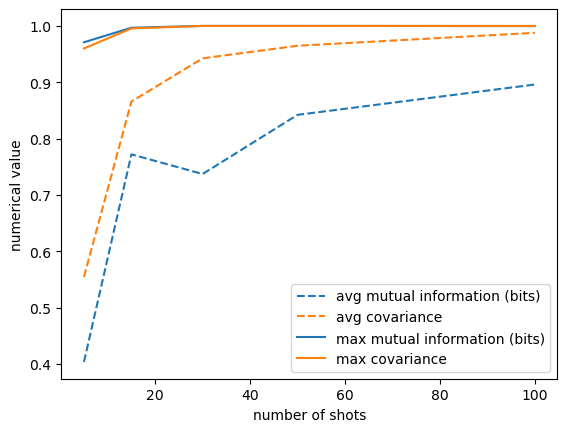

In [80]:
with open("../data/maxent_finite_shot_2023-03-27T22:29:53.651848.json", "r") as openfile:
    data = json.load(openfile)
    shots_list = data["shots_list"]
    char_mat_data = data["char_mat_data"]
    cov_mat_data = data["cov_mat_data"]

    plot_result(shots_list, char_mat_data, cov_mat_data)
    plt.legend()

## W-state test

In [40]:
def w_state_prep_node():
    def rot_w_state(settings, wires):
        qnetvo.W_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])

    w_state_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=rot_w_state)
    return w_state_prep_node

In [41]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            w_state_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(w_state_prep_node(), num_steps=30, step_size=0.05, shots=shots)
        for t in range(trial)
    ]
    for shots in shots_list
]

save_results(shots_list, char_mat_data, cov_mat_data, "wstate_finite_shot")

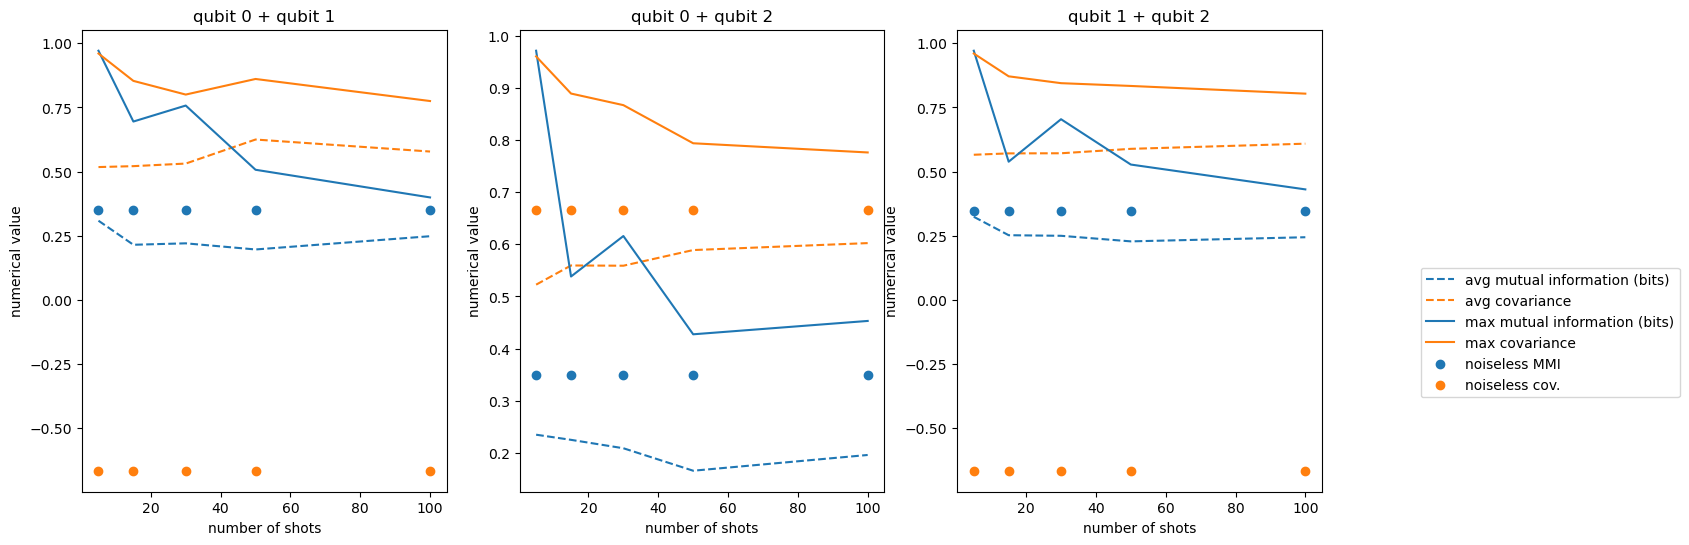

In [73]:
with open("../data/wstate_finite_shot_2023-03-27T00:12:34.872968.json", "r") as openfile:
    data = json.load(openfile)
    shots_list = data["shots_list"]
    char_mat_data = data["char_mat_data"]
    cov_mat_data = data["cov_mat_data"]

    idx_list = [[0, 1], [0, 2], [1, 2]]
    noiseless_mmi = qnp.array(
        characteristic_matrix_inference(
            w_state_prep_node(), num_steps=100, step_size=0.05, shots=None
        )
    )
    noiseless_cov = qnp.array(
        covariance_matrix_inference(w_state_prep_node(), num_steps=100, step_size=0.05, shots=None)
    )

    plt.figure(figsize=(16, 6))
    for i, idx in enumerate(idx_list):
        plt.subplot(1, 3, i + 1)
        idx_1 = idx[0]
        idx_2 = idx[1]

        plt.title("qubit " + str(idx_1) + " + qubit " + str(idx_2))

        plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=idx_1, idx_2=idx_2)

        plt.scatter(
            shots_list,
            [abs(noiseless_mmi[idx_1, idx_2]) for s in shots_list],
            color="#1f77b4",
            label="noiseless MMI",
        )
        plt.scatter(
            shots_list,
            [noiseless_cov[idx_1, idx_2] for s in shots_list],
            color="#ff7f0e",
            label="noiseless cov.",
        )
    plt.legend(bbox_to_anchor=(1.5, 0.0, 0.5, 0.5))

The figure above shows a possible advantage of entropic inference. In the low-shot regime, it seems like estimating the entropy is easier to do than estimating the covariance (gap between lines and dots). If we put ourselves strictly in the context of inferring topology, covariance methods has a slight advantage since it is, by nature, further away from zero. However, maybe the precision is needed sometimes. 

# No entanglement test

In [63]:
def loc_rot_prep_node():
    def local_rot_state(settings, wires):
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])

    loc_rot_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=local_rot_state)
    return loc_rot_prep_node

In [64]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            loc_rot_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(loc_rot_prep_node(), num_steps=30, step_size=0.05, shots=shots)
        for t in range(trial)
    ]
    for shots in shots_list
]

save_results(shots_list, char_mat_data, cov_mat_data, "noent_finite_shot")

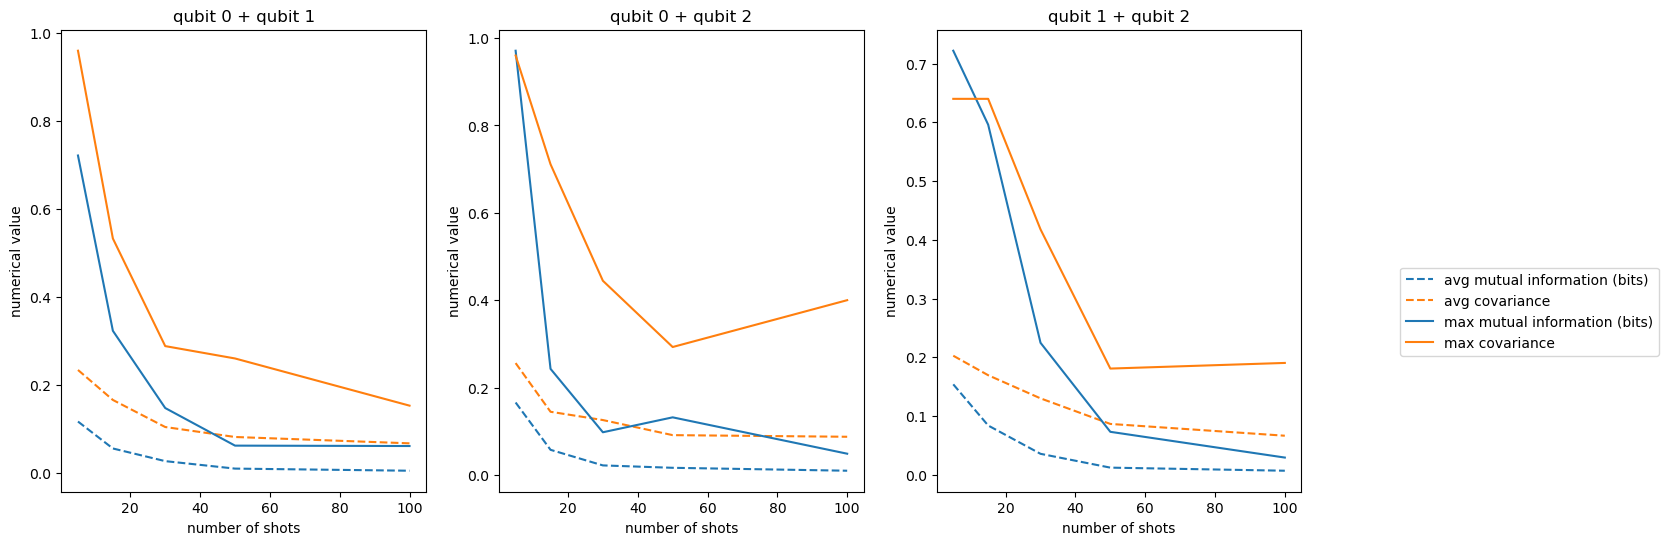

In [74]:
with open("../data/noent_finite_shot_2023-03-27T21:21:28.956953.json", "r") as openfile:
    data = json.load(openfile)
    shots_list = data["shots_list"]
    char_mat_data = data["char_mat_data"]
    cov_mat_data = data["cov_mat_data"]

    idx_list = [[0, 1], [0, 2], [1, 2]]
    plt.figure(figsize=(16, 6))
    for i, idx in enumerate(idx_list):
        plt.subplot(1, 3, i + 1)
        idx_1 = idx[0]
        idx_2 = idx[1]

        plt.title("qubit " + str(idx_1) + " + qubit " + str(idx_2))

        plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=idx_1, idx_2=idx_2)

    plt.legend(bbox_to_anchor=(1.5, 0.0, 0.5, 0.5))

As we hoped, when no correlation exist, we have a stronger tendency of falsely thinking the qubits are entangled when looking at the covariance, particularly so in the low-shot regime. 

## Full network example 

Let's considera 5-qubit network. Qubits 0, 1, and 2 are entangled in a W state. Qubits 3 and 4 are maximally entangled. We apply local rotations after the entanglement to each qubit. Our goal is to recover the structure of the network---qubits 0, 1, and 2 are from the same preparation node, and qubits 3 and 4 are from another preparation node.

In [67]:
def network_prep_node():
    def network_state(settings, wires):
        qnetvo.W_state(settings, wires=[wires[0], wires[1], wires[2]])
        qnetvo.ghz_state(settings, wires=[wires[3], wires[4]])
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])
        qml.ArbitraryUnitary([1.3, 5, -0.8], wires=[wires[3]])
        qml.ArbitraryUnitary([5.5, -2.3, 1], wires=[wires[4]])

    prep_node = qnetvo.PrepareNode(wires=[0, 1, 2, 3, 4], ansatz_fn=network_state)
    return prep_node

In [68]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            network_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(network_prep_node(), num_steps=30, step_size=0.05, shots=shots)
        for t in range(trial)
    ]
    for shots in shots_list
]

save_results(shots_list, char_mat_data, cov_mat_data, "network_finite_shot")

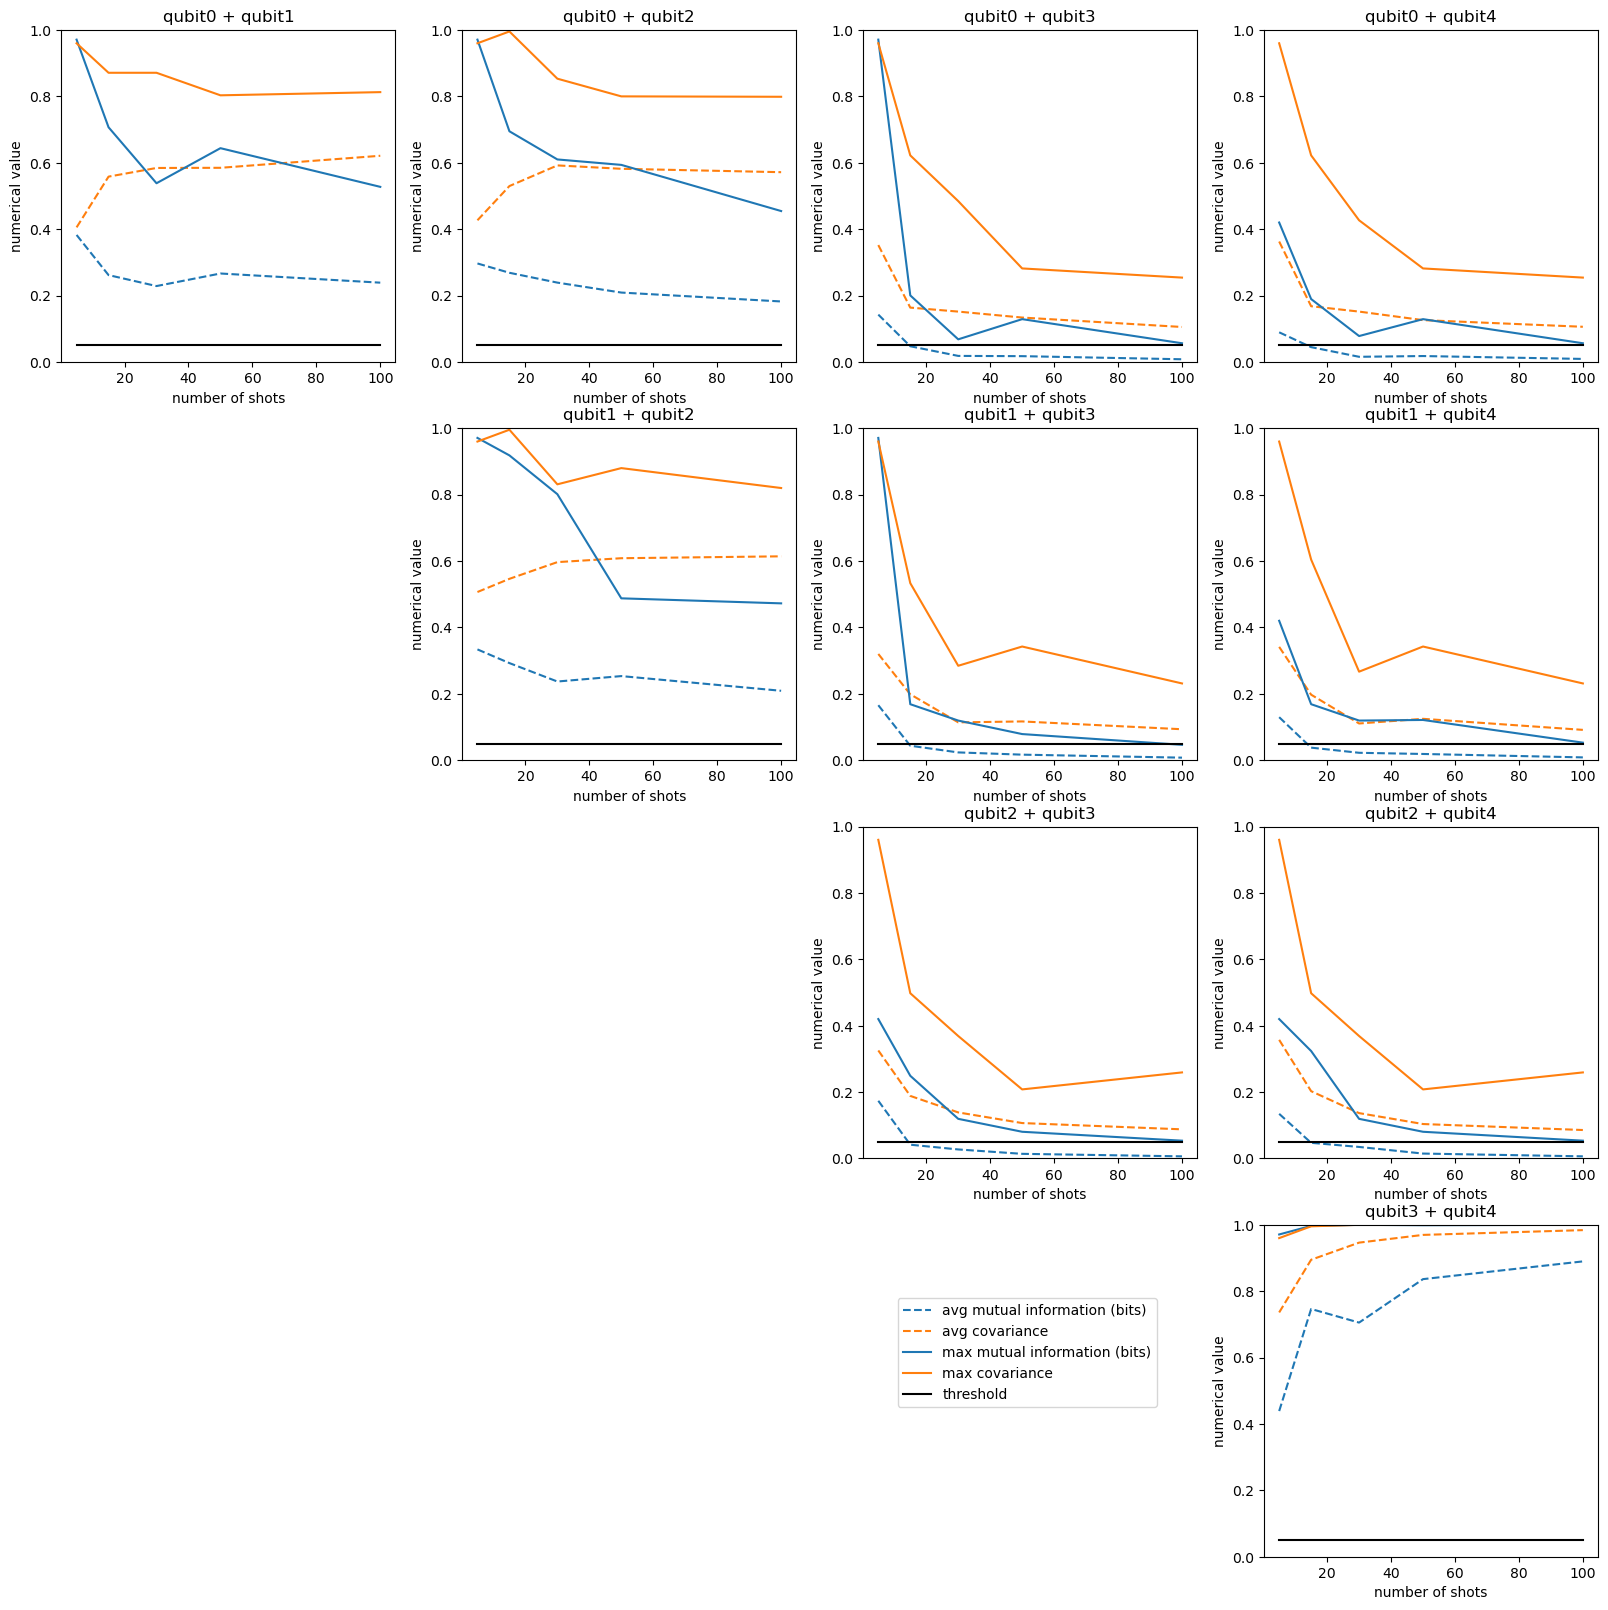

In [75]:
with open("../data/network_finite_shot_2023-03-27T22:12:03.848812.json", "r") as openfile:
    data = json.load(openfile)
    shots_list = data["shots_list"]
    char_mat_data = data["char_mat_data"]
    cov_mat_data = data["cov_mat_data"]
    plt.figure(figsize=(25, 25))
    for i in range(0, 5):
        for j in range(i + 1, 5):
            plt.subplot(5, 5, i * 5 + j)

            idx_1 = i
            idx_2 = j

            plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=idx_1, idx_2=idx_2)
            plt.plot(shots_list, [0.05 for s in shots_list], "k", label="threshold")
            plt.title("qubit" + str(idx_1) + " + qubit" + str(idx_2))
            plt.ylim([0, 1])

    plt.legend(bbox_to_anchor=(-0.3, 0.8))

We set the threshold to be 0.05, that is, we would guess that the two qubits come from the same preparation node if and only if the measured mutual information/covariance exceeds the threshold. We see that, when the qubits are entangled, both methods are capable to identifying existing correlations. However, covariance methods suffer in the low-shot regime in the absence of correlation, whereas mutual information rapidly vanishes when no correlation exists.